# Assignment 4: Learning to Rank

In this assignment you will implement a pointwise, pairwise and listwise Learning to Rank (LTR) losses to optimize three ranking models and evaluate the differences in their performance.

For this assignment, an additional notebook is provided with examples of Numpy and Tensorflow code that could be useful for this assignment.

## Dataset Setup

First we will download a dataset and some helper files.

In [ ]:
!wget http://gem.cs.ru.nl/IR-Course/LTR-dataset.npz
!wget http://gem.cs.ru.nl/IR-Course/dataset.py
!wget http://gem.cs.ru.nl/IR-Course/optimization.py
!wget http://gem.cs.ru.nl/IR-Course/evaluate.py

--2023-10-10 12:03:28--  http://gem.cs.ru.nl/IR-Course/LTR-dataset.npz
Resolving gem.cs.ru.nl (gem.cs.ru.nl)... 131.174.31.31
Connecting to gem.cs.ru.nl (gem.cs.ru.nl)|131.174.31.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 634123360 (605M)
Saving to: ‘LTR-dataset.npz’

LTR-dataset.npz     100%[===================>] 604.75M  10.5MB/s    in 44s     

2023-10-10 12:04:13 (13.7 MB/s) - ‘LTR-dataset.npz’ saved [634123360/634123360]

--2023-10-10 12:04:13--  http://gem.cs.ru.nl/IR-Course/dataset.py
Resolving gem.cs.ru.nl (gem.cs.ru.nl)... 131.174.31.31
Connecting to gem.cs.ru.nl (gem.cs.ru.nl)|131.174.31.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4800 (4.7K) [text/x-python]
Saving to: ‘dataset.py’

dataset.py          100%[===================>]   4.69K  --.-KB/s    in 0s      

2023-10-10 12:04:13 (280 MB/s) - ‘dataset.py’ saved [4800/4800]

--2023-10-10 12:04:13--  http://gem.cs.ru.nl/IR-Course/optimization.py
Resolving gem.cs

Next, import the numpy and tensorflow packages and some additional files that will help us with loading data and optimization of the models.

In [ ]:
import numpy as np
import tensorflow as tf
import dataset
import optimization as opt
import time

The dataset has been pre-processed for you, we will start by loading it with our custom dataset package.

In [ ]:
data = dataset.load(path='LTR-dataset.npz')

print('Data has been loaded in, here are some statistics:')
print('Number of features: %d' % data.num_features)
print('Number of queries in training set: %d' % data.train.num_queries())
print('Number of documents in training set: %d' % data.train.num_docs())
print('Number of queries in validation set: %d' % data.validation.num_queries())
print('Number of documents in validation set: %d' % data.validation.num_docs())

Data has been loaded in, here are some statistics:
Number of features: 501
Number of queries in training set: 19943
Number of documents in training set: 473092
Number of queries in validation set: 2993
Number of documents in validation set: 71041


You will not need to work with the dataset directly, the optimization package will handle that for you. This assignment will only cover the implementation loss functions.

# 1 Pointwise Learning to Rank

There first loss to implement is the **pointwise** [Mean-Squared-Error](https://en.wikipedia.org/wiki/Mean_squared_error) (MSE) regression loss:
$$L = \frac{1}{D} \sum_{d}(\hat{y}_d - y_d)^2.$$
Here $D$ is the set of documents (pre-selected for a single query) and $\hat{y}_d$ is the predicted score for document $d$ whereas $y_d$ is the true label.

Complete the function below so that it provides the pointwise MSE loss, such that it can be used by Tensorflow for gradient calculation.

In [ ]:
def pointwise_loss(predicted_scores, true_labels):
    # replace the following nonsense loss with the MSE loss
    loss = tf.reduce_mean(tf.math.square(predicted_scores - true_labels))
    return loss

If you get stuck, the [following tutorial](https://www.tensorflow.org/tutorials/customization/basics) may be helpful with the Tensorflow aspects for this assignment.
Also remember that there is a helper notebook that explains some useful Numpy and Tensorflow functionality.

The assertions below will test whether your implementation returns the correct loss values in some scenarios.

In [ ]:
assert np.isclose(pointwise_loss(tf.convert_to_tensor([0.,0.]),np.array([0,0], dtype=int)), 0)
assert np.isclose(pointwise_loss(tf.convert_to_tensor([1.,0.]),np.array([0,1], dtype=int)), 1)
assert np.isclose(pointwise_loss(tf.convert_to_tensor([2.,-2.]),np.array([0,1], dtype=int)), 6.5)
assert np.isclose(pointwise_loss(tf.convert_to_tensor([2.5,-0.2]),np.array([0,1], dtype=int)), 3.845)
assert np.isclose(pointwise_loss(tf.convert_to_tensor([2.5,-0.2]),np.array([1,0], dtype=int)), 1.145)

Pointwise loss functions are usually very fast, nonetheless, the below code will check if your implementation is fast enough for practical use.

The test will look at the gradient computation speed for the second query (query-ID=1), this is a relatively lightweight query with only a few documents:

In [ ]:
count = 0
model, optimizer = opt.init_model()
start_time = time.time()
while time.time() - start_time < 3:
    opt.one_optimization_step(data, 1, pointwise_loss, model, optimizer)
    count += 1
seconds_lapsed = time.time() - start_time
print('Seconds run: %s' % seconds_lapsed)
print('Iterations completed: %d' % count)
print('Iterations per second: %d' % (count/seconds_lapsed))
print('Seconds per iteration: %s' % (seconds_lapsed/count))
assert count > 100

Seconds run: 3.012566089630127
Iterations completed: 143
Iterations per second: 47
Seconds per iteration: 0.02106689573167921


The next test will look at one of the queries with the most pre-selected documents, this is a more heavyweight test:

In [ ]:
count = 0
model, optimizer = opt.init_model()
start_time = time.time()
while time.time() - start_time < 3:
    opt.one_optimization_step(data, 4756, pointwise_loss, model, optimizer)
    count += 1
seconds_lapsed = time.time() - start_time
print('Seconds run: %s' % seconds_lapsed)
print('Iterations completed: %d' % count)
print('Iterations per second: %d' % (count/seconds_lapsed))
print('Seconds per iteration: %s' % (seconds_lapsed/count))
assert count > 100

Seconds run: 3.0223467350006104
Iterations completed: 134
Iterations per second: 44
Seconds per iteration: 0.02255482638060157


The following code will run your loss function for 5 epochs, this is a very low number of epochs, but provides a relatively fast way to test your implementation.

If the assertions above pass but the optimization below does not, then it is likely that tensorflow cannot derive gradients from your result. This could be the case because your implementation relies on numpy functions instead of tensorflow functions. The error message may indicate if this is the case.

Epoch 0 - NDCG@10: 0.536
Epoch 1 - Loss 1.430 - NDCG@10: 0.684
Epoch 2 - Loss 0.855 - NDCG@10: 0.701
Epoch 3 - Loss 0.762 - NDCG@10: 0.709
Epoch 4 - Loss 0.735 - NDCG@10: 0.718
Epoch 5 - Loss 0.720 - NDCG@10: 0.726
Final results:
dcg: 18.8472 (14.28637)
dcg@03: 8.4062 (6.94699)
dcg@05: 10.3390 (7.77850)
dcg@10: 13.3099 (9.27772)
dcg@20: 16.0638 (11.17463)
ndcg: 0.8286 (0.14344)
ndcg@03: 0.6423 (0.28467)
ndcg@05: 0.6692 (0.24942)
ndcg@10: 0.7258 (0.21889)
ndcg@20: 0.7768 (0.18403)
precision@01: 0.5663 (0.49559)
precision@03: 0.3964 (0.29202)
precision@05: 0.3196 (0.22757)
precision@10: 0.2303 (0.16840)
precision@20: 0.1533 (0.12069)
recall@01: 0.2454 (0.32298)
recall@03: 0.4388 (0.37240)
recall@05: 0.5554 (0.37265)
recall@10: 0.7162 (0.33353)
recall@20: 0.8643 (0.24384)
relevant rank: 13.4764 (14.42119)
relevant rank per query: 54.0158 (102.85645)


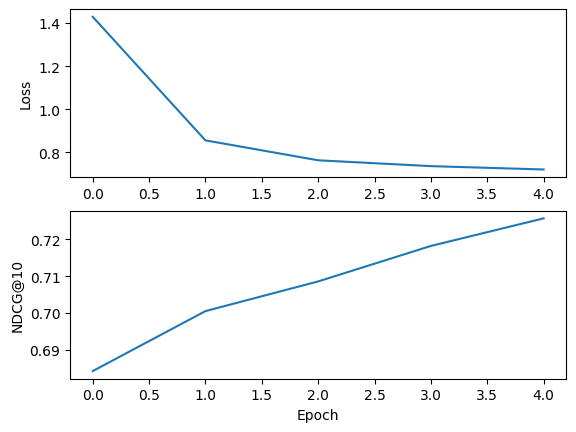

In [ ]:
opt.optimization(data, pointwise_loss, num_epochs=5)

The real assignment is to complete 50 epochs, this can take around 30 minutes. We recommend you first finish the rest of the assignment before you complete this task.

# 2 Pairwise Learning to Rank
Implement the pairwise loss from the [LambdaLoss paper](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/1e34e05e5e4bf2d12f41eb9ff29ac3da9fdb4de3.pdf):
$$L = \frac{1}{|\{y_{d_i} > y_{d_j}\}|}\sum_{y_{d_i} > y_{d_j}}\log(1 + e^{\hat{y}_{d_j} - \hat{y}_{d_i}}).$$
The $y_{d_i} > y_{d_j}$ indicates that the label of document $i$ is greater than $j$, i.e. $d_i$ is more relevant than $d_j$, and $\sum_{y_{d_i} > y_{d_j}}$ sums over all document pairs with unequal labels.

Your implementation needs to be fast enough to be practical, the best way to do this is by using [broadcasting](https://www.tensorflow.org/guide/tensor#broadcasting). The helper notebook has some useful examples to help you on your way.

Complete the function below:

In [ ]:
def pairwise_loss(predicted_scores, true_labels):
    i,j = np.where(np.greater(true_labels[:,None]-true_labels[None,:], 0))
    if i.shape[0] == 0 :
      return 0
    loss = tf.reduce_mean(tf.math.log(1+tf.exp(tf.math.subtract(tf.gather(predicted_scores, j),tf.gather(predicted_scores, i)))))
    return loss

Here are some test scenarios:

In [ ]:
assert np.isclose(pairwise_loss(tf.convert_to_tensor([1.]),np.array([1], dtype=int)), 0)
assert np.isclose(pairwise_loss(tf.convert_to_tensor([0.,0.]),np.array([0,0], dtype=int)), 0)
assert np.isclose(pairwise_loss(tf.convert_to_tensor([1.,0.]),np.array([0,1], dtype=int)), 1.3132616)
assert np.isclose(pairwise_loss(tf.convert_to_tensor([2.,-2.]),np.array([0,1], dtype=int)), 4.01815)
assert np.isclose(pairwise_loss(tf.convert_to_tensor([2.5,-0.2]),np.array([0,1], dtype=int)), 2.7650435)
assert np.isclose(pairwise_loss(tf.convert_to_tensor([2.5,-0.2]),np.array([1,0], dtype=int)), 0.06504359)
assert np.isclose(pairwise_loss(tf.convert_to_tensor([1.,2.,3.,4.,5.]),np.array([5,1,3,2,4], dtype=int)), 1.2749155)

Your code should not only be correct, but also fast enough to enable feasible optimization. The following two tests will test how quick your implementation is.

In [ ]:
count = 0
model, optimizer = opt.init_model()
start_time = time.time()
while time.time() - start_time < 3:
    opt.one_optimization_step(data, 1, pairwise_loss, model, optimizer)
    count += 1
seconds_lapsed = time.time() - start_time
print('Seconds run: %s' % seconds_lapsed)
print('Iterations completed: %d' % count)
print('Iterations per second: %d' % (count/seconds_lapsed))
print('Seconds per iteration: %s' % (seconds_lapsed/count))
assert count > 100

Seconds run: 3.009368419647217
Iterations completed: 107
Iterations per second: 35
Seconds per iteration: 0.02812493850137586


In [ ]:
count = 0
model, optimizer = opt.init_model()
start_time = time.time()
while time.time() - start_time < 3:
    opt.one_optimization_step(data, 4756, pairwise_loss, model, optimizer)
    count += 1
seconds_lapsed = time.time() - start_time
print('Seconds run: %s' % seconds_lapsed)
print('Iterations completed: %d' % count)
print('Iterations per second: %d' % (count/seconds_lapsed))
print('Seconds per iteration: %s' % (seconds_lapsed/count))
assert count > 100

Seconds run: 3.0105583667755127
Iterations completed: 110
Iterations per second: 36
Seconds per iteration: 0.027368712425231933


Finally, test your implementation by running 5 epochs.

Epoch 0 - NDCG@10: 0.531
Epoch 1 - Loss 0.592 - NDCG@10: 0.730
Epoch 2 - Loss 0.558 - NDCG@10: 0.738
Epoch 3 - Loss 0.550 - NDCG@10: 0.743
Epoch 4 - Loss 0.546 - NDCG@10: 0.743
Epoch 5 - Loss 0.543 - NDCG@10: 0.745
Final results:
dcg: 19.2394 (14.78109)
dcg@03: 8.9036 (7.37536)
dcg@05: 10.8787 (8.29264)
dcg@10: 13.8292 (9.81329)
dcg@20: 16.5566 (11.74203)
ndcg: 0.8409 (0.14087)
ndcg@03: 0.6706 (0.27967)
ndcg@05: 0.6944 (0.24562)
ndcg@10: 0.7452 (0.21380)
ndcg@20: 0.7928 (0.17850)
precision@01: 0.6100 (0.48774)
precision@03: 0.4227 (0.30562)
precision@05: 0.3374 (0.24046)
precision@10: 0.2393 (0.17607)
precision@20: 0.1576 (0.12559)
recall@01: 0.2564 (0.31892)
recall@03: 0.4602 (0.37510)
recall@05: 0.5692 (0.37075)
recall@10: 0.7332 (0.32958)
recall@20: 0.8793 (0.23398)
relevant rank: 12.5441 (13.68570)
relevant rank per query: 50.2790 (95.76996)


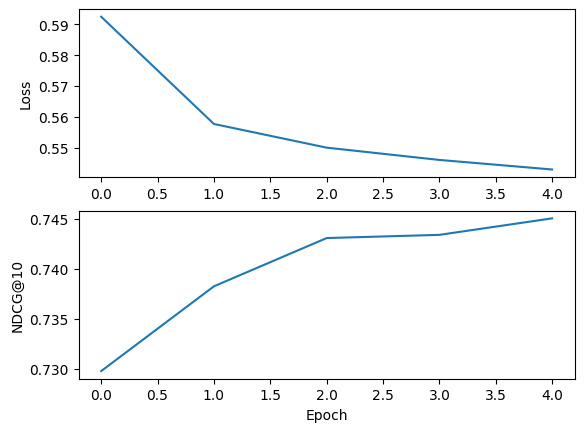

In [ ]:
opt.optimization(data, pairwise_loss, num_epochs=5)

# 3 Listwise Learning to Rank

Implement the listwise loss from the [original listwise LTR paper](http://icml2008.cs.helsinki.fi/papers/167.pdf), this paper models the probability of a ranking as a Plackett-Luce model (similar to a soft-max function). As the loss function we will use the negative log-likelihood of the optimal ranking.
Let $R$ denote the optimal ranking for query $q$, ${R[i]}$ as the $i$th document in the optimal ranking and $\hat{y}_{R[i]}$ as its predicted score, the loss is then:
$$L = - \sum_{i = 1}^{|R|} \log\left( \frac{ \exp\left(\hat{y}_{R[i]} \right)}{\sum_{j=i}^{|R|} \exp\left(\hat{y}_{R[j]}\right)} \right).$$

Please note that the denominator sum starts at $i$ and **not** at $1$.

Use broadcasting to make your implementation fast.
Complete the function below:

In [ ]:
def listwise_loss(predicted_scores, true_labels):
   # make true_labels start indexing from 0
    true_labels -= 1
    sorted_indices = tf.argsort(true_labels)
    sorted_scores = tf.gather(predicted_scores, sorted_indices)
    cumsum = tf.cumsum(tf.exp(sorted_scores))
    loss = -tf.reduce_sum(tf.math.log(tf.math.divide(tf.exp(sorted_scores),cumsum)))
    return loss

The following assertions will test the correctness of your implementation in some scenarios.

In [ ]:
assert np.isclose(listwise_loss(tf.convert_to_tensor([1.]),np.array([1], dtype=int)), 0)
assert np.isclose(listwise_loss(tf.convert_to_tensor([1.,0.]),np.array([0,1], dtype=int)), 1.3132616)
assert np.isclose(listwise_loss(tf.convert_to_tensor([2.,-2.]),np.array([0,1], dtype=int)), 4.01815)
assert np.isclose(listwise_loss(tf.convert_to_tensor([2.5,-0.2]),np.array([0,1], dtype=int)), 2.7650435)
assert np.isclose(listwise_loss(tf.convert_to_tensor([2.5,-0.2]),np.array([1,0], dtype=int)), 0.065043524)
assert np.isclose(listwise_loss(tf.convert_to_tensor([1.,2.,3.,4.,5.]),np.array([5,1,3,2,4], dtype=int)), 6.4266376)

The tests below verify whether your implementation is fast enough to be usable in practice.

In [ ]:
count = 0
model, optimizer = opt.init_model()
start_time = time.time()
while time.time() - start_time < 3:
    opt.one_optimization_step(data, 1, listwise_loss, model, optimizer)
    count += 1
seconds_lapsed = time.time() - start_time
print('Seconds run: %s' % seconds_lapsed)
print('Iterations completed: %d' % count)
print('Iterations per second: %d' % (count/seconds_lapsed))
print('Seconds per iteration: %s' % (seconds_lapsed/count))
assert count > 100

Seconds run: 3.002747058868408
Iterations completed: 111
Iterations per second: 36
Seconds per iteration: 0.027051775305120793


In [ ]:
count = 0
model, optimizer = opt.init_model()
start_time = time.time()
while time.time() - start_time < 3:
    opt.one_optimization_step(data, 4756, listwise_loss, model, optimizer)
    count += 1
seconds_lapsed = time.time() - start_time
print('Seconds run: %s' % seconds_lapsed)
print('Iterations completed: %d' % count)
print('Iterations per second: %d' % (count/seconds_lapsed))
print('Seconds per iteration: %s' % (seconds_lapsed/count))
assert count > 100

Seconds run: 3.0132806301116943
Iterations completed: 113
Iterations per second: 37
Seconds per iteration: 0.026666200266475173


Lastly, verify whether you can complete 5 epochs.

Epoch 0 - NDCG@10: 0.610
Epoch 1 - Loss 59.366 - NDCG@10: 0.727
Epoch 2 - Loss 59.070 - NDCG@10: 0.735
Epoch 3 - Loss 58.993 - NDCG@10: 0.739
Epoch 4 - Loss 58.941 - NDCG@10: 0.738
Epoch 5 - Loss 58.907 - NDCG@10: 0.741
Final results:
dcg: 19.1431 (14.72237)
dcg@03: 8.7681 (7.23576)
dcg@05: 10.7742 (8.19412)
dcg@10: 13.7359 (9.73708)
dcg@20: 16.4860 (11.69927)
ndcg: 0.8372 (0.14259)
ndcg@03: 0.6645 (0.28055)
ndcg@05: 0.6903 (0.24684)
ndcg@10: 0.7412 (0.21477)
ndcg@20: 0.7897 (0.17970)
precision@01: 0.5832 (0.49303)
precision@03: 0.4197 (0.30720)
precision@05: 0.3361 (0.24298)
precision@10: 0.2396 (0.17768)
precision@20: 0.1581 (0.12652)
recall@01: 0.2447 (0.31624)
recall@03: 0.4514 (0.37481)
recall@05: 0.5618 (0.37293)
recall@10: 0.7339 (0.33054)
recall@20: 0.8795 (0.23436)
relevant rank: 12.6076 (13.75230)
relevant rank per query: 50.5336 (95.83085)


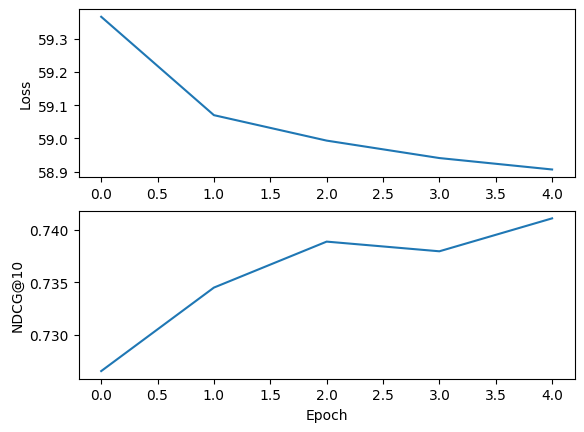

In [ ]:
opt.optimization(data, listwise_loss, num_epochs=5)

# 4 Full Training

At this point, you should be ready to fully complete 25 epochs of training per epoch.

Run the below code, this may take over an hour in total, so it may be a good idea to something else while it runs. For example, you could grab a coffee or tea and look at the list of projects for the remainder of this course.

## Pointwise Loss - 25 Epochs

Epoch 0 - NDCG@10: 0.513
Epoch 1 - Loss 25.497 - NDCG@10: 0.475
Epoch 2 - Loss 17.889 - NDCG@10: 0.478
Epoch 3 - Loss 16.965 - NDCG@10: 0.495
Epoch 4 - Loss 16.879 - NDCG@10: 0.538
Epoch 5 - Loss 16.868 - NDCG@10: 0.595
Epoch 6 - Loss 16.860 - NDCG@10: 0.631
Epoch 7 - Loss 16.851 - NDCG@10: 0.660
Epoch 8 - Loss 16.840 - NDCG@10: 0.675
Epoch 9 - Loss 16.828 - NDCG@10: 0.687
Epoch 10 - Loss 16.813 - NDCG@10: 0.694
Epoch 11 - Loss 16.792 - NDCG@10: 0.697
Epoch 12 - Loss 16.770 - NDCG@10: 0.699
Epoch 13 - Loss 16.742 - NDCG@10: 0.702
Epoch 14 - Loss 16.709 - NDCG@10: 0.705
Epoch 15 - Loss 16.676 - NDCG@10: 0.706
Epoch 16 - Loss 16.652 - NDCG@10: 0.708
Epoch 17 - Loss 16.630 - NDCG@10: 0.710
Epoch 18 - Loss 16.616 - NDCG@10: 0.715
Epoch 19 - Loss 16.615 - NDCG@10: 0.719
Epoch 20 - Loss 16.597 - NDCG@10: 0.722
Epoch 21 - Loss 16.593 - NDCG@10: 0.723
Epoch 22 - Loss 16.581 - NDCG@10: 0.724
Epoch 23 - Loss 16.578 - NDCG@10: 0.724
Epoch 24 - Loss 16.572 - NDCG@10: 0.725
Epoch 25 - Loss 16.566 -

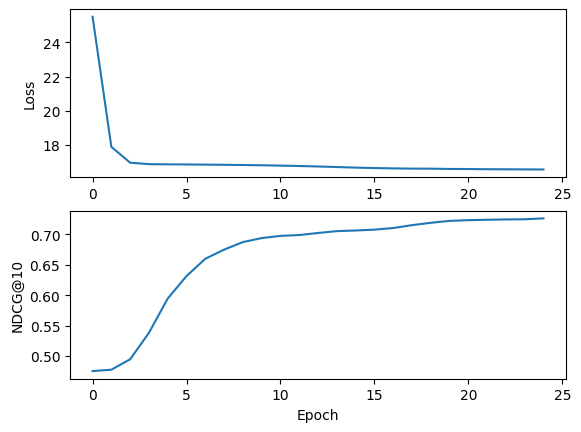

In [ ]:
pointwise_model = opt.optimization(data, pointwise_loss, num_epochs=25)

## Pairwise Loss - 25 Epochs

Epoch 0 - NDCG@10: 0.504
Epoch 1 - Loss 0.597 - NDCG@10: 0.729
Epoch 2 - Loss 0.560 - NDCG@10: 0.738
Epoch 3 - Loss 0.552 - NDCG@10: 0.741
Epoch 4 - Loss 0.547 - NDCG@10: 0.743
Epoch 5 - Loss 0.544 - NDCG@10: 0.743
Epoch 6 - Loss 0.542 - NDCG@10: 0.747
Epoch 7 - Loss 0.539 - NDCG@10: 0.747
Epoch 8 - Loss 0.538 - NDCG@10: 0.747
Epoch 9 - Loss 0.535 - NDCG@10: 0.749
Epoch 10 - Loss 0.534 - NDCG@10: 0.751
Epoch 11 - Loss 0.532 - NDCG@10: 0.751
Epoch 12 - Loss 0.530 - NDCG@10: 0.750
Epoch 13 - Loss 0.529 - NDCG@10: 0.752
Epoch 14 - Loss 0.527 - NDCG@10: 0.750
Epoch 15 - Loss 0.526 - NDCG@10: 0.755
Epoch 16 - Loss 0.524 - NDCG@10: 0.753
Epoch 17 - Loss 0.523 - NDCG@10: 0.755
Epoch 18 - Loss 0.522 - NDCG@10: 0.755
Epoch 19 - Loss 0.520 - NDCG@10: 0.757
Epoch 20 - Loss 0.519 - NDCG@10: 0.756
Epoch 21 - Loss 0.518 - NDCG@10: 0.756
Epoch 22 - Loss 0.517 - NDCG@10: 0.757
Epoch 23 - Loss 0.516 - NDCG@10: 0.757
Epoch 24 - Loss 0.514 - NDCG@10: 0.756
Epoch 25 - Loss 0.513 - NDCG@10: 0.756
Final res

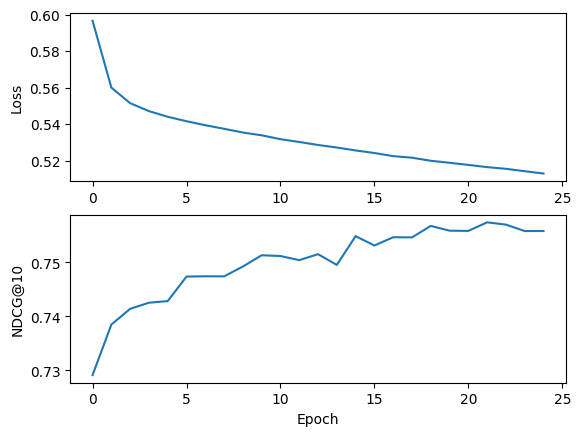

In [ ]:
pairwise_model = opt.optimization(data, pairwise_loss, num_epochs=25)

## Listwise Loss - 25 Epochs

Epoch 0 - NDCG@10: 0.525
Epoch 1 - Loss 59.460 - NDCG@10: 0.725
Epoch 2 - Loss 59.089 - NDCG@10: 0.733
Epoch 3 - Loss 58.996 - NDCG@10: 0.739
Epoch 4 - Loss 58.938 - NDCG@10: 0.740
Epoch 5 - Loss 58.895 - NDCG@10: 0.738
Epoch 6 - Loss 58.859 - NDCG@10: 0.742
Epoch 7 - Loss 58.832 - NDCG@10: 0.744
Epoch 8 - Loss 58.806 - NDCG@10: 0.744
Epoch 9 - Loss 58.777 - NDCG@10: 0.746
Epoch 10 - Loss 58.752 - NDCG@10: 0.747
Epoch 11 - Loss 58.731 - NDCG@10: 0.747
Epoch 12 - Loss 58.715 - NDCG@10: 0.748
Epoch 13 - Loss 58.697 - NDCG@10: 0.749
Epoch 14 - Loss 58.677 - NDCG@10: 0.750
Epoch 15 - Loss 58.663 - NDCG@10: 0.751
Epoch 16 - Loss 58.645 - NDCG@10: 0.753
Epoch 17 - Loss 58.637 - NDCG@10: 0.751
Epoch 18 - Loss 58.620 - NDCG@10: 0.753
Epoch 19 - Loss 58.609 - NDCG@10: 0.753
Epoch 20 - Loss 58.597 - NDCG@10: 0.751
Epoch 21 - Loss 58.581 - NDCG@10: 0.752
Epoch 22 - Loss 58.568 - NDCG@10: 0.754
Epoch 23 - Loss 58.560 - NDCG@10: 0.753
Epoch 24 - Loss 58.551 - NDCG@10: 0.754
Epoch 25 - Loss 58.543 -

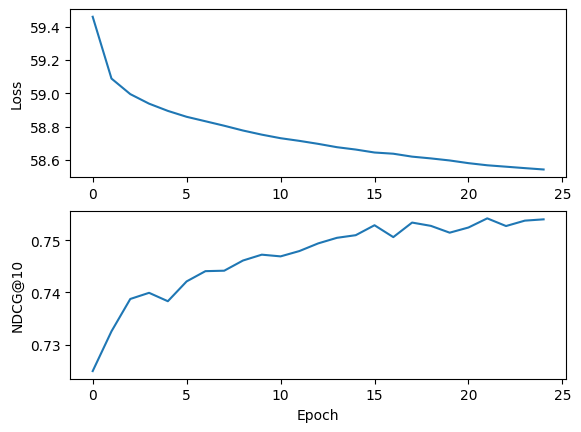

In [ ]:
listwise_model = opt.optimization(data, listwise_loss, num_epochs=25)

# 5 Reflection

Look and compare the loss and DCG plots for the different LTR methods.
Discuss the differences you see and how this relates to the LTR theory.

The loss and NDCG@10 plots for the three approaches seem to contain some observable differences. First, the loss curve in the pointwise approach follows a sharp decrease after the 3 or 4 epochs, while the NDCG@10 plot has a smooth increase until around the 10th epoch, followed by a slower increase. This behavior on both plots can be explained because the pointwise approach uses the regression technique where the aim is to minimize the error loss function and also because this technique ignores the position of each document in the ranking list and provides a prediction for relevance between document and query, which means that more relevant documents receive higher positions within the top 10.
Conversely, the loss graphs for the pairwise and listwise approaches demonstrate a steady decline compared to the pointwise approach. This declination is expected since pairwise and listwise approaches focus on optimizing the entire ranked list while the pointwise approach optimizes the individual document prediction. Moreover, the NDCG@10 plot displays more fluctuations, while it increases, on the pairwise approach than the listwise approach. This observation aligns with LTR theory as the pairwise approach compares pairs of documents which means that it is more sensitive to small changes between each pair of documents than the listwise approach that focuses on the optimization of the entire ranked list of documents.

# 6 Submit your runs for the test set
The following code will create a submission file which you will hand in for evaluation.

Replace the placeholders with your student number and name.

In [ ]:
student_number = 's1122141'
student_first_name = 'FOTEINI'
student_last_name = 'PAPADOPOULOU'
output_path = '%s_%s_%s_LTR_assignment.json' % (student_number, student_first_name, student_last_name)
dataset.output_model_scores(output_path, data, pointwise_model, pairwise_model, listwise_model)